# Angabe

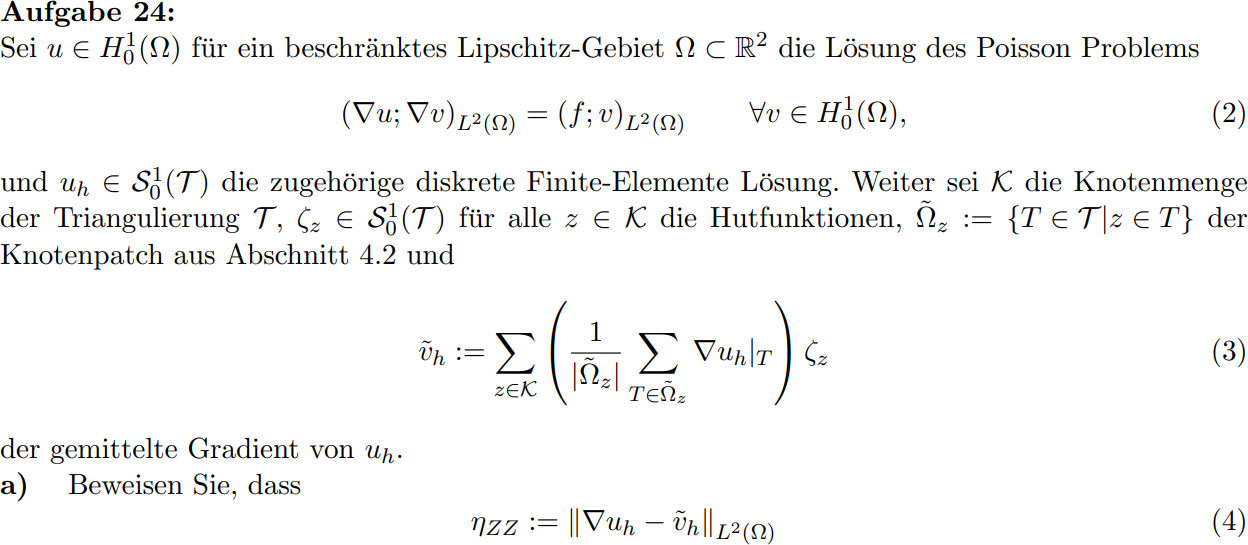
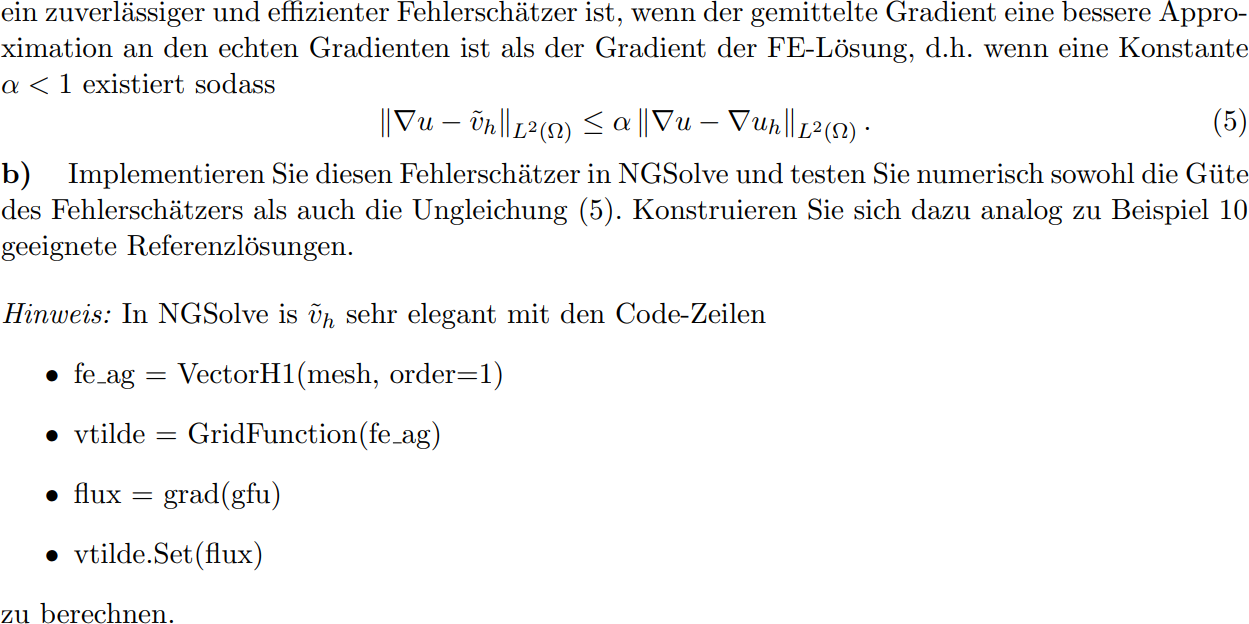

# Vorbereitungen

## Pakete etc. importieren

In [1]:
import numpy as np
import ngsolve as ngs
import matplotlib.pyplot as plt

from ngsolve.webgui import Draw
from netgen.geom2d import SplineGeometry

## Geometrie & Gebiet definieren

In [2]:
geo = SplineGeometry()
geo.AddRectangle((0, 0), (10, 10), bcs = ['bottom', 'right', 'top', 'left'])

## Referenzlösung definieren

In [3]:
sol_ref = ngs.exp(-2 * ((ngs.x - 4) ** 2 + (ngs.y - 6)**2))

sol_ref_dx = sol_ref.Diff(ngs.x)
sol_ref_dy = sol_ref.Diff(ngs.y)

rhs          = - sol_ref_dx.Diff(ngs.x) - sol_ref_dy.Diff(ngs.y)
sol_ref_grad = ngs.CoefficientFunction((sol_ref_dx, sol_ref_dy))

## Ordnung festlegen

Laut Angabe benützen wir lineare Polynome.

In [4]:
order = 1

# Weiterer Verlauf im Detail

## Erstellen des Meshes

In [5]:
mesh = ngs.Mesh(geo.GenerateMesh(maxh=0.1))

## Erstellen der FES

Hier stellen wir zwei verschiedene FES auf.
Auf einem haben wir die Lösungsfunktion und am anderen unser $\tilde{v}_h$.

In [6]:
fes = ngs.H1(mesh, order = order)
fe_ag = ngs.VectorH1(mesh, order = order)

sol_approx = ngs.GridFunction(fes)
sol_approx_grad_avg = ngs.GridFunction(fe_ag)

## Aufstellen der Bilinear und Linearform

In [7]:
u = fes.TrialFunction()
v = fes.TestFunction()

a = ngs.BilinearForm(fes, symmetric = True)
a += (ngs.grad(u) * ngs.grad(v)) * ngs.dx
a.Assemble()

f = ngs.LinearForm(fes)
f += rhs * v * ngs.dx
f.Assemble()

## Ausrechnen und Zeichnen der Approximationen der Lösung

Mehr zur `Set`-Methode ist hier zu finden:
https://ngsolve.org/docu/latest/i-tutorials/unit-1.2-coefficient/coefficientfunction.html#Interpolate-a-function

In [8]:
sol_approx.vec.data = a.mat.Inverse(freedofs = fes.FreeDofs()) * f.vec

flux = ngs.grad(sol_approx)

# Set Methode Interpoliert
# It then projects myfunc in L2 on each mesh element;
# It then averages dofs on element interfaces for conformity.
sol_approx_grad_avg.Set(flux)

Draw(flux, mesh)
Draw(sol_approx_grad_avg, mesh)

NGSWebGuiWidget(value={'ngsolve_version': '6.2.2008', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'draw_vol': F…

NGSWebGuiWidget(value={'ngsolve_version': '6.2.2008', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'draw_vol': F…

## Fehler Berechnen und anzeigen

In [9]:
H1err = ngs.sqrt(
    ngs.Integrate(
        (sol_ref_grad - ngs.grad(sol_approx))**2 + ngs.InnerProduct(
            sol_ref_grad - ngs.grad(sol_approx),
            sol_ref_grad - ngs.grad(sol_approx)),
        mesh,
        ngs.VOL,
        order * 2
    )
)
eta_ZZ = ngs.sqrt(
    ngs.Integrate(
        ngs.InnerProduct(
            ngs.grad(sol_approx) - sol_approx_grad_avg,
            ngs.grad(sol_approx) - sol_approx_grad_avg
        ),
        mesh,
        ngs.VOL,
        order * 2
    )
)

print(H1err)
print(eta_ZZ)

L2err_grad_std = ngs.sqrt(
    ngs.Integrate(
        ngs.InnerProduct(
            sol_ref_grad - ngs.grad(sol_approx),
            sol_ref_grad - ngs.grad(sol_approx)
        ),
        mesh,
        ngs.VOL,
        order * 2
    )
)
L2err_grad_avg = ngs.sqrt(
    ngs.Integrate(
        ngs.InnerProduct(
            sol_ref_grad - sol_approx_grad_avg,
            sol_ref_grad - sol_approx_grad_avg
        ),
        mesh,
        ngs.VOL,
        order * 2
    )
)

print(L2err_grad_std)
print(L2err_grad_avg)

0.17891495682333974
0.12846813646412034
0.12651197922548188
0.03393032617912735


# "Weiterer Verlauf" für Plots

## Back-End

Vorerst berechnen wir alle möglichen Fehler, um diese dann anschließend unabhängig davon zu plotten.

In [10]:
# ---------------------------------------------------------------- #
# setup x- & y-axis

# maximum diameters of elements (x-axis)
maxh = np.array([1 / 2 ** n for n in range(1, 6)])

# initiatlize containers (y-axis)

H1err_array = []
eta_ZZ_array = []

L2err_grad_std_array = []
L2err_grad_avg_array = []

# ---------------------------------------------------------------- #

for h in maxh:

    # create mesh with maximum diameter h
    mesh = ngs.Mesh(geo.GenerateMesh(maxh = h))
    
    # create Finite Element Spaces from mesh
    fes = ngs.H1(mesh, order = order)
    fe_ag = ngs.VectorH1(mesh, order = order)

    # initiate symbolic container for averaged gradient
    sol_approx_grad_avg = ngs.GridFunction(fe_ag)

    # initiate symbolic container for approximate solution
    sol_approx = ngs.GridFunction(fes)

    # initiate symbolic containers for ...
    u = fes.TrialFunction()
    v = fes.TestFunction()

    # setup bilinear form
    a = ngs.BilinearForm(fes, symmetric = True)
    a += (ngs.grad(u) * ngs.grad(v)) * ngs.dx
    a.Assemble()

    # setup linear functional
    f = ngs.LinearForm(fes)
    f += rhs * v * ngs.dx
    f.Assemble()
    
    # calculate solution and fill result into previously setup symbolic container
    sol_approx.vec.data = a.mat.Inverse(freedofs = fes.FreeDofs()) * f.vec

    # determine gradient of approximate solution
    flux = ngs.grad(sol_approx)

    # 'Oswald'-interpolate gradient and fill result into previously setup symbolic container
    sol_approx_grad_avg.Set(flux)

    # calculate errors
    H1err_array.append(
        ngs.sqrt(
            ngs.Integrate(
                (sol_ref_grad - ngs.grad(sol_approx)) ** 2 + ngs.InnerProduct(
                    sol_ref_grad - ngs.grad(sol_approx),
                    sol_ref_grad - ngs.grad(sol_approx)
                ),
                mesh,
                ngs.VOL,
                order * 2
            )
        )
    )
    eta_ZZ_array.append(
        ngs.sqrt(
            ngs.Integrate(
                ngs.InnerProduct(
                    ngs.grad(sol_approx) - sol_approx_grad_avg,
                    ngs.grad(sol_approx) - sol_approx_grad_avg),
                mesh,
                ngs.VOL,
                order * 2
            )
        )
    )
    L2err_grad_std_array.append(
        ngs.sqrt(
            ngs.Integrate(
                ngs.InnerProduct(
                    sol_ref_grad - ngs.grad(sol_approx),
                    sol_ref_grad - ngs.grad(sol_approx)
                ),
                mesh,
                ngs.VOL,
                order * 2
            )
        )
    )
    L2err_grad_avg_array.append(
        ngs.sqrt(
            ngs.Integrate(
                ngs.InnerProduct(
                    sol_ref_grad - sol_approx_grad_avg,
                    sol_ref_grad - sol_approx_grad_avg
                ),
                mesh,
                ngs.VOL,
                order * 2
            )
        )
    )

# ---------------------------------------------------------------- #

## Front-End

Folgende Abbildung zeigt, dass $\eta_{ZZ}$ tatsächlich ein zuverlässiger sowie effiezienter Fehlerschätzer ist.

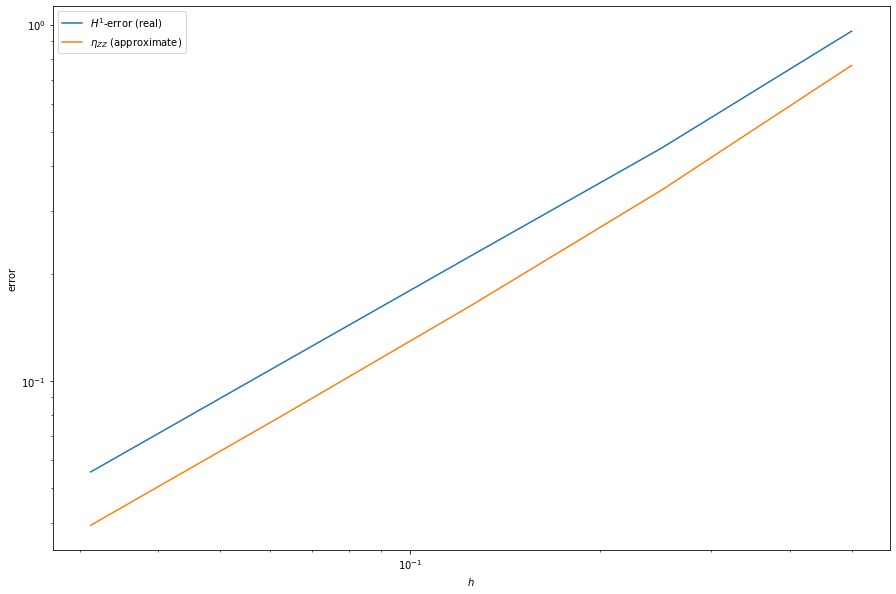

In [11]:
fig = plt.figure(figsize = (15, 10))

plt.loglog(maxh, H1err_array,  label = "$H^1$-error (real)")
plt.loglog(maxh, eta_ZZ_array, label = "$\eta_{ZZ}$ (approximate)")

plt.xlabel("$h$")
plt.ylabel("error")

plt.legend()
plt.show()

Wir vergleichen nun die rechte mit der linken Seite von (5).
Das war die Gleichung mit dem $\alpha > 0$.

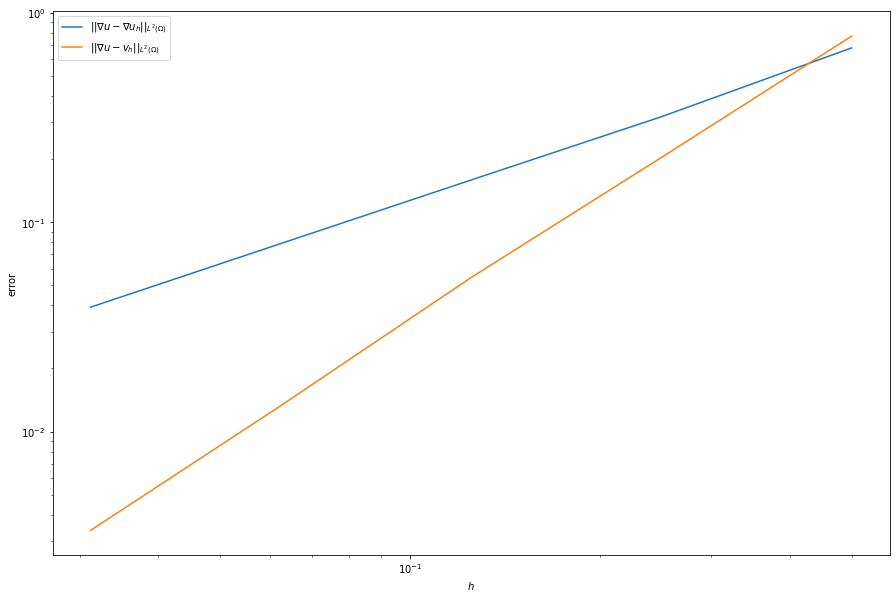

In [12]:
fig = plt.figure(figsize = (15, 10))

plt.loglog(maxh, L2err_grad_std_array, label = r"$|| \nabla u - \nabla u_h ||_{L^2(\Omega)}$")
plt.loglog(maxh, L2err_grad_avg_array, label = r"$|| \nabla u - v_h ||_{L^2(\Omega)}$")

plt.xlabel("$h$")
plt.ylabel("error")

plt.legend()
plt.show()